### Loading Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.preprocessing import normalize
from keras import backend



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import glob 
import math 
import shutil
import os
import time
plt.rcParams['figure.figsize'] = [15, 5]
base_log_dir = "./logs/"
sns.set_style("darkgrid")

if not os.path.exists(base_log_dir):
    os.makedirs(base_log_dir)

### Plotting utils

In [3]:
def CalculateMetricsAndPlot(true_label, predicted_label,color="Blues",text="",is_show=True):
    if is_show:
        plt.rcParams['figure.figsize'] = [9, 6]
    CM = confusion_matrix(true_label, predicted_label)
    acc = round(accuracy_score(true_label,predicted_label)*100,2)
    precision = round(precision_score(true_label,predicted_label, average='macro'),2)
    if text == "":
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix (Test)| Accuracy={0}% | Precision={1}".format(acc,precision))
    else :
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix (Test)| Accuracy={0}% | Precision={1} | {2}".format(acc,precision,text))
    if is_show:
        plt.show()

def TrainingPlot(_history,text=None,is_show=True):
    if is_show :
        plt.rcParams['figure.figsize'] = [15, 5]
    plt.subplot(1,2,1)
    plt.plot(_history["loss"],label="Train loss")
    plt.plot(_history["val_loss"],label="Validation loss")
    if not text is None:
        plt.title("Loss/Epoch | {0}".format(text))
    else:
        plt.title("Loss/Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Sparse Categorical Crossentropy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(_history["accuracy"],label="Train accuracy")
    plt.plot(_history["val_accuracy"],label="Validation accuracy")
    if not text is None:
        plt.title("Accuracy/Epoch | {0}".format(text))
    else:
        plt.title("Accuracy/Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy in %")
    plt.legend()
  
    plt.tight_layout()
    if is_show:
        plt.show()
        
    plt.show()


### Loading Dataset & Pre

In [4]:
def LabelProcess(label):
    if label in ['normal', "ok"]:
        return 1 
    return 0 

def GetDataset(path="./"):
    data = ""
    for i in range(1,6):        
        d = open(path+"lp{0}.data".format(i),"r").read()
        d = "\n" + d 
        data += d + "\n"
    
    data = list(data.split("\n\n"))
    Y = []
    _y = []
    X = np.zeros(shape=(len(data)-2,15,6))
    
    for index in range(len(data)-2):
        lines = list(data[index].split("\n"))
        
        _y.append(lines[1])
        Y.append(LabelProcess(lines[1]))
        
        tmp = np.zeros(shape=(15,6))
        lines = lines[2:]
        for i in range(15):
            line = lines[i]
            elements = list(line.split("\t"))
            for j in range(6):
                tmp[i,j] = int(elements[j+1])
        X[index,:,:] = tmp
        
    return X,np.array(Y)
   
        
X_total,Y_total = GetDataset()   
tmp = normalize(np.reshape(X_total,newshape=(X_total.shape[0],15*6)))
X_total = np.reshape(X_total,newshape=(tmp.shape[0],15,6))

X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.2,stratify=Y_total)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.125,stratify=Y_train)

### Jordan Cell

In [5]:
class JordanCell(keras.layers.SimpleRNNCell):
    def __init__(self,n=2,**kwargs):
        super(JordanCell, self).__init__(**kwargs)   
        self.softmax_layer = tf.keras.layers.Dense(n, activation='softmax')
        self.n = n

    def call(self, inputs, states, training=None):
        output,new_state = super().call(
            inputs=inputs, states = states, training=training
        )
        new_state = output
        zeros = tf.zeros_like(new_state)
        predict = self.softmax_layer(new_state)
        _merge = Concatenate()([zeros[:,:new_state.shape[1]-self.n],predict])
        return predict,[_merge]

### Separate dataset

In [6]:
def Separate(n:int):
    _0 = np.where(Y_train==0)[0]
    _1 = np.where(Y_train==1)[0]
    
    np.random.shuffle(_0)
    np.random.shuffle(_1)
    

    _0_index = np.array_split(_0,n)
    _1_index = np.array_split(_1,n)
    
    return _0_index,_1_index

    

### Sub-net with random data

In [9]:
def random_sub_net_trainer(Units):
    keras.backend.clear_session()
    models = []
    histories = []
    N = []
    n = len(Units)
    _0 , _1 = Separate(n)
    for index in range(n):
        _new_X_train = np.concatenate([X_train[_0[index]],X_train[_1[index]]])
        _new_Y_train = np.concatenate([Y_train[_0[index]],Y_train[_1[index]]])

        model  = Sequential()                           
        model.add(keras.layers.SimpleRNN(Units[index] , activation='relu',input_shape=(15,6)))
        model.add(keras.layers.Dense(2 , activation='softmax'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
        History = model.fit(_new_X_train,_new_Y_train,validation_data=(X_valid,Y_valid),epochs=200,verbose=0)
        models.append(model)
        N.append(Units[index])
        histories.append(History.history)
        print("Passed Elman:",Units[index])
        model.evaluate(X_test,Y_test)
        
    
    _input = Input(shape=(15,6))
    out_models = [] 
    for model in models :
        out_models.append(model(_input))

    _avg = Average()(out_models)
    out = keras.activations.softmax(_avg)

    MODEL_1 = keras.Model(inputs=_input,outputs=out)
    CalculateMetricsAndPlot(Y_test,np.argmax(MODEL_1.predict(X_test),axis=1),"Purples","Ensemble Elman networks with random data | Sub-net:{0}".format(n))


    plt.rcParams['figure.figsize'] = [18, 6*n//2]
    for i in range(1,n+1):
        plt.subplot(n//2,2,i)
        CalculateMetricsAndPlot(Y_test,np.argmax(models[i-1].predict(X_test),axis=1),
                                "Blues","Ensemble random data #{0}|Neuron:{1}|Sub-net:{2}".format(i,N[i-1],n),is_show=False)

    plt.tight_layout()
    plt.show()
    
    plt.rcParams['figure.figsize'] = [20, 5]
    for i in range(1,n+1):
        plt.subplot(n,1,i)
        TrainingPlot(histories[i-1],"Ensemble random #{0} | Neuron:{1} | Sub-net:{2}".format(i,N[i-1],n).format(i),is_show=False)

 
    

### Sub-net: 2 (Same net)

Passed Elman: 40
3/3 [==============================] - 0s 3ms/step - loss: 0.5404 - accuracy: 0.9247
Passed Elman: 40
3/3 [==============================] - 0s 3ms/step - loss: 0.3753 - accuracy: 0.9570


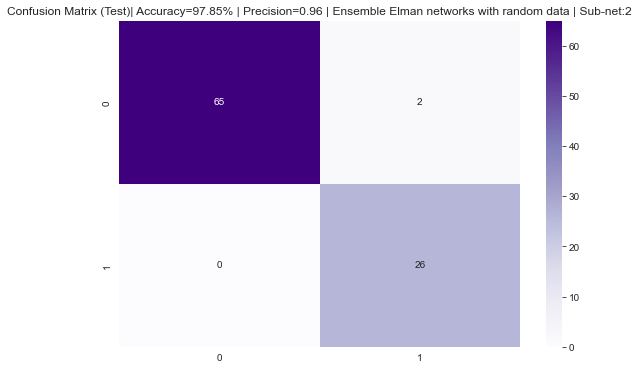

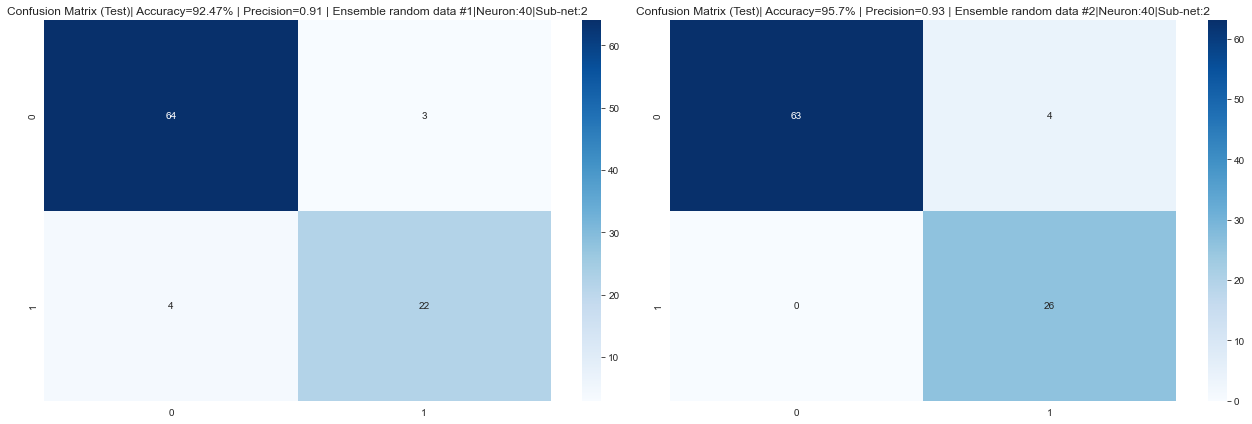

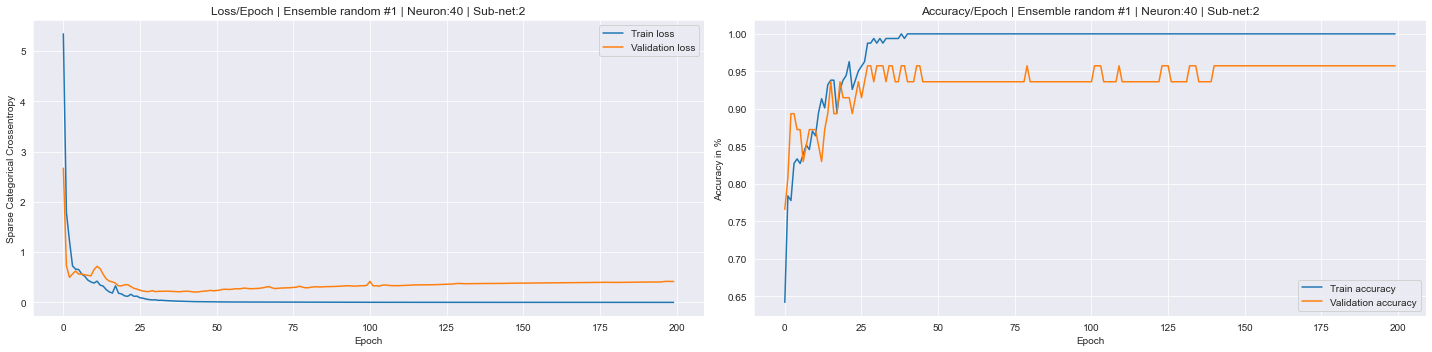

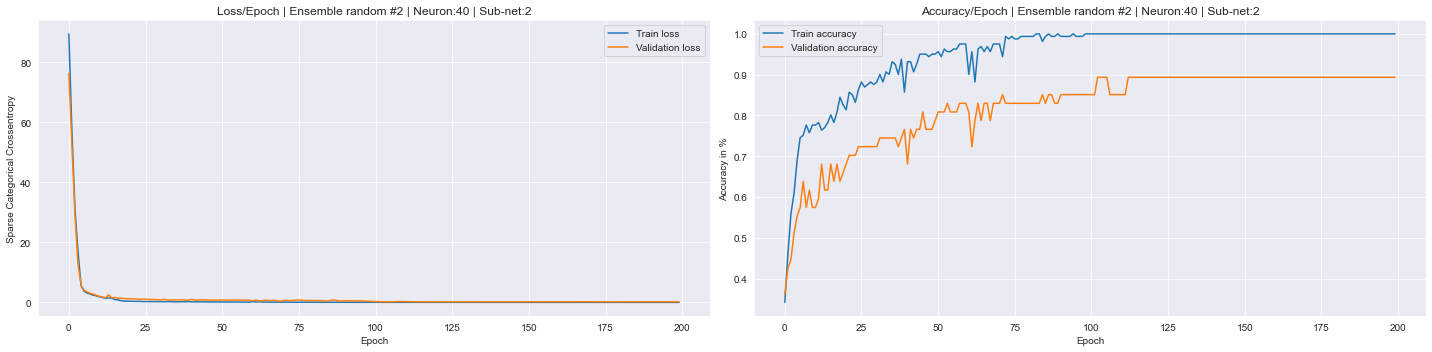

In [10]:
random_sub_net_trainer([40]*2)     

### Sub-net: 4 (Same net)

Passed Elman: 40
3/3 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.9247
Passed Elman: 40
3/3 [==============================] - 0s 3ms/step - loss: 1.1132 - accuracy: 0.8172
Passed Elman: 40
3/3 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.8495
Passed Elman: 40
3/3 [==============================] - 0s 3ms/step - loss: 0.8051 - accuracy: 0.8065


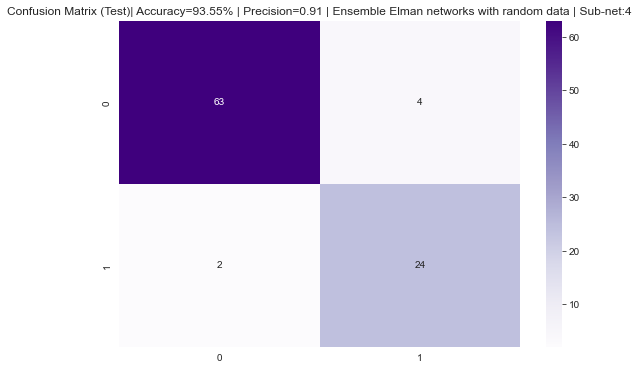

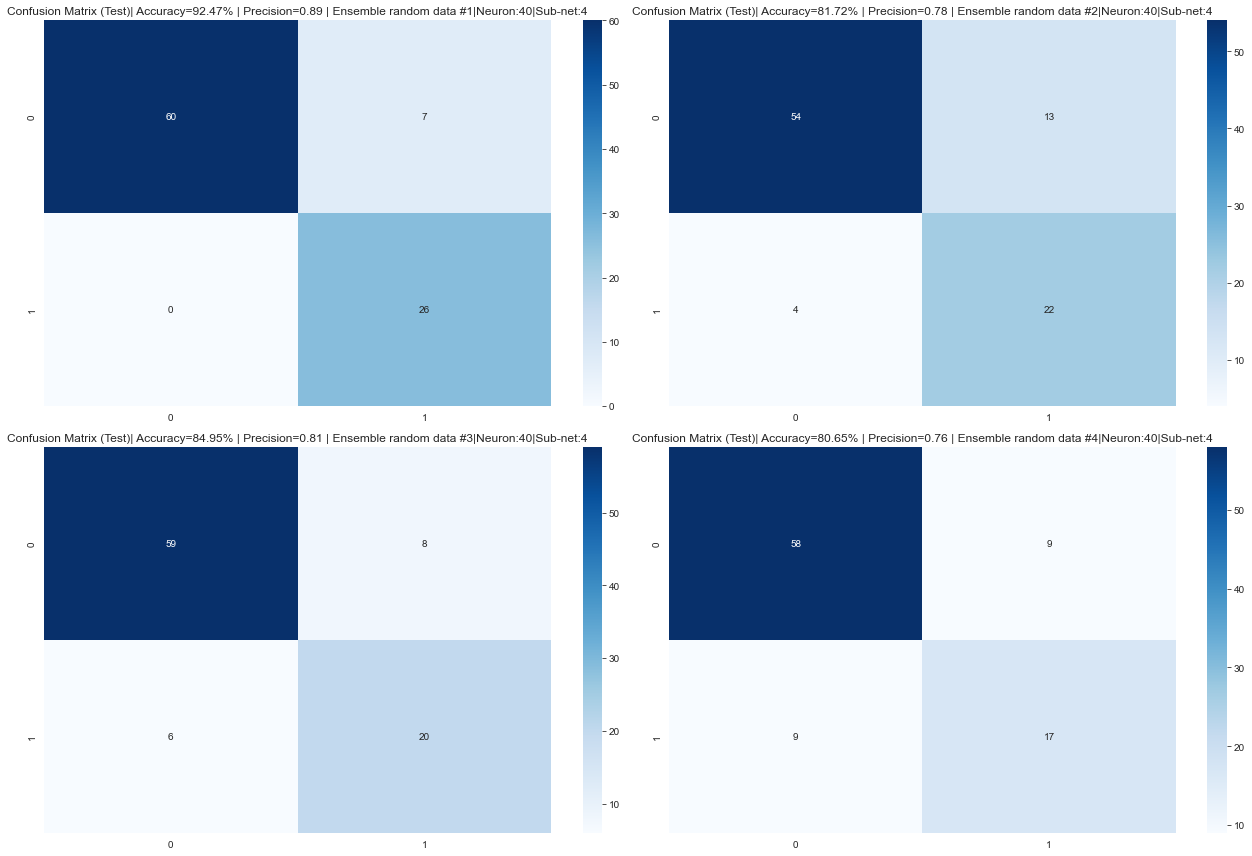

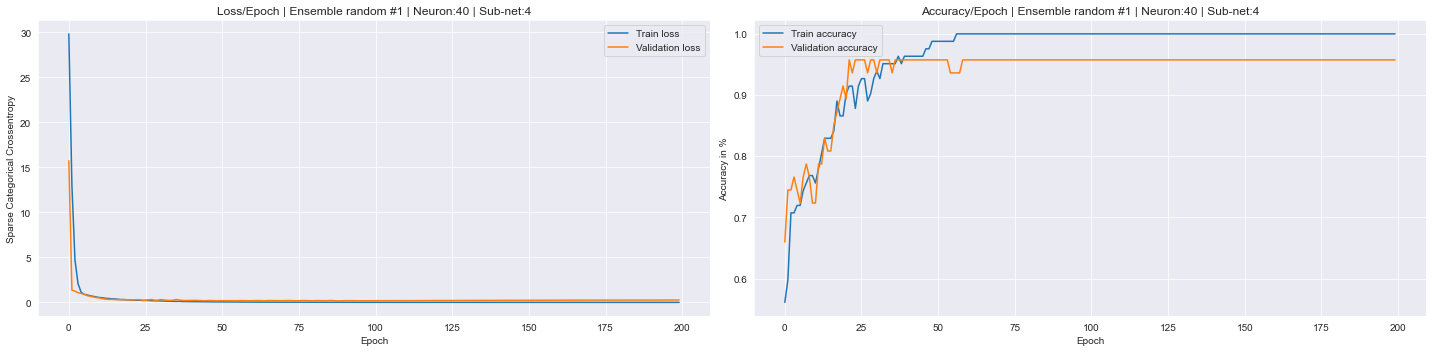

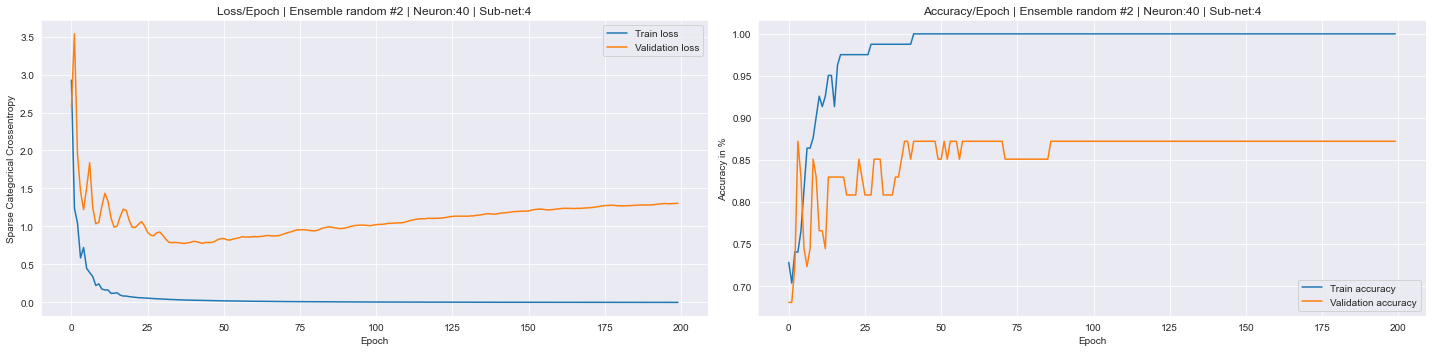

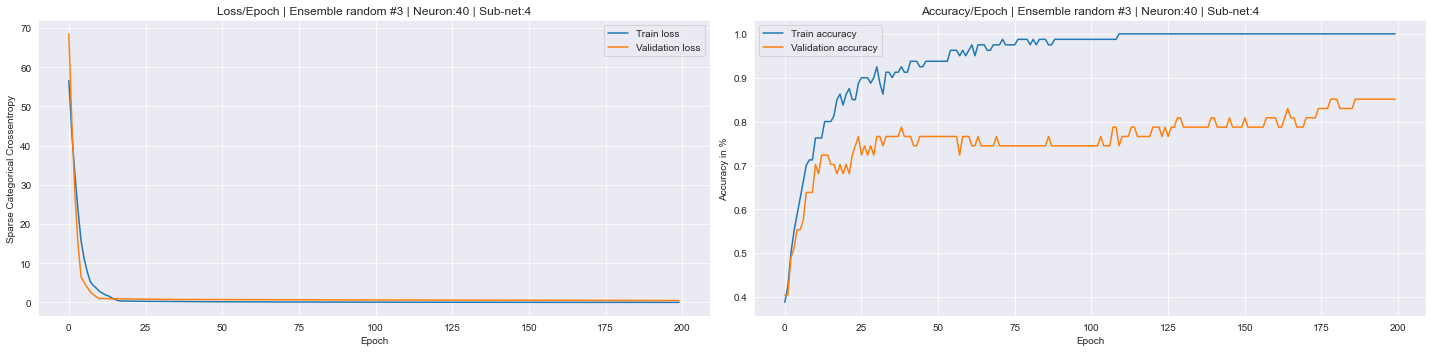

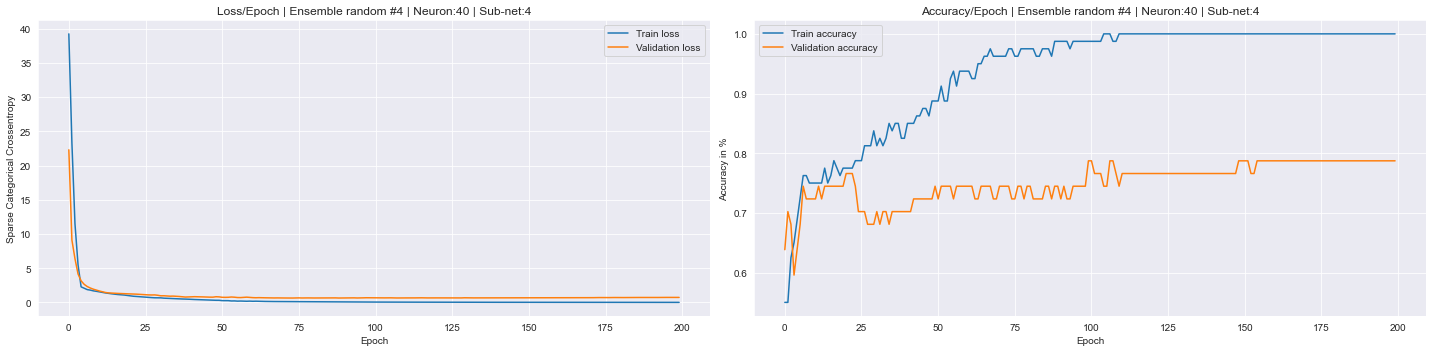

In [11]:
random_sub_net_trainer([40]*4)     

### Sub-net: 6 (Same net)

Passed Elman: 40
3/3 [==============================] - 0s 4ms/step - loss: 0.4634 - accuracy: 0.8817
Passed Elman: 40
3/3 [==============================] - 0s 2ms/step - loss: 2.4459 - accuracy: 0.7634
Passed Elman: 40
3/3 [==============================] - 0s 4ms/step - loss: 1.0655 - accuracy: 0.8495
Passed Elman: 40
3/3 [==============================] - 0s 2ms/step - loss: 1.7735 - accuracy: 0.8280
Passed Elman: 40
3/3 [==============================] - 0s 6ms/step - loss: 5.1602 - accuracy: 0.7419
Passed Elman: 40
3/3 [==============================] - 0s 3ms/step - loss: 1.0187 - accuracy: 0.8065


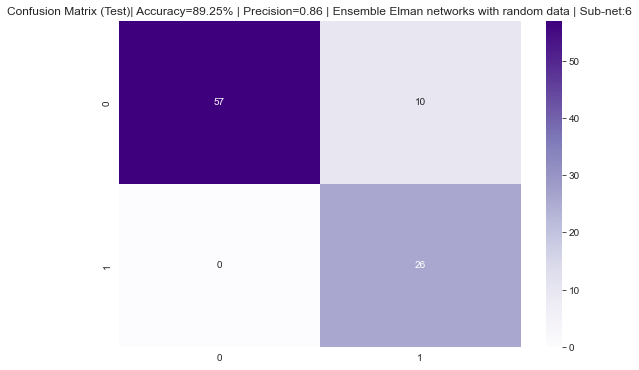

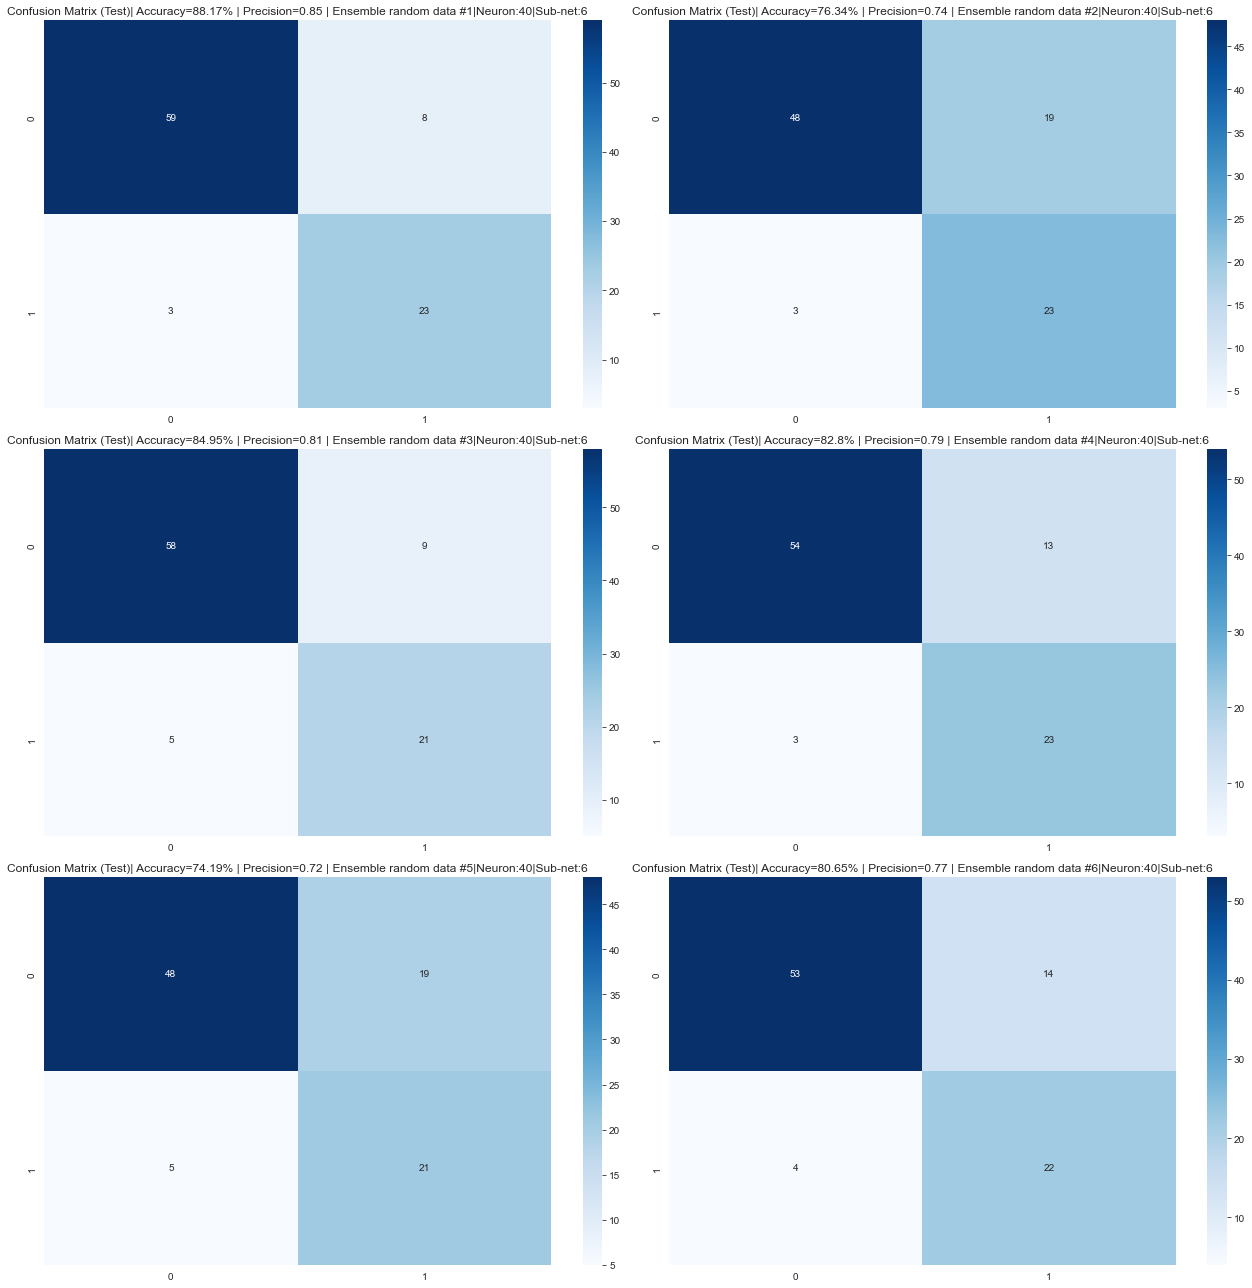

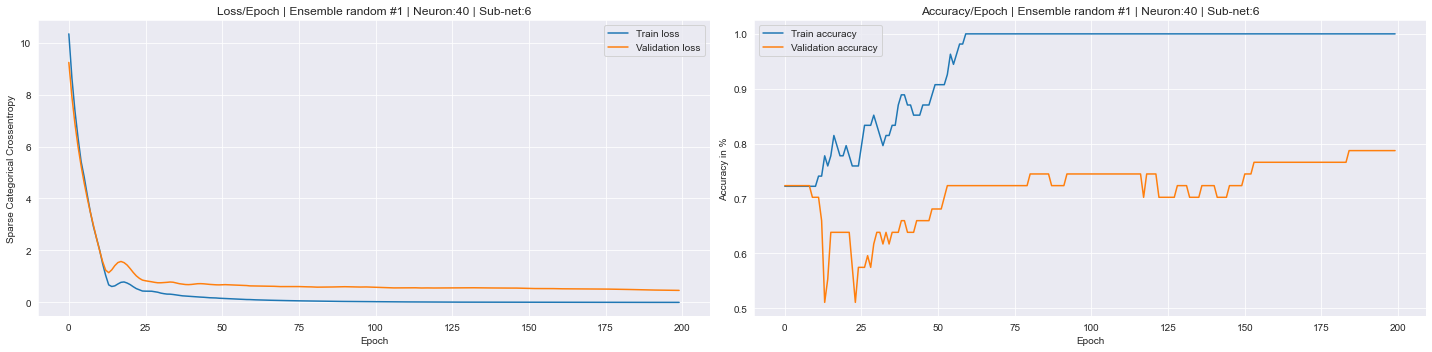

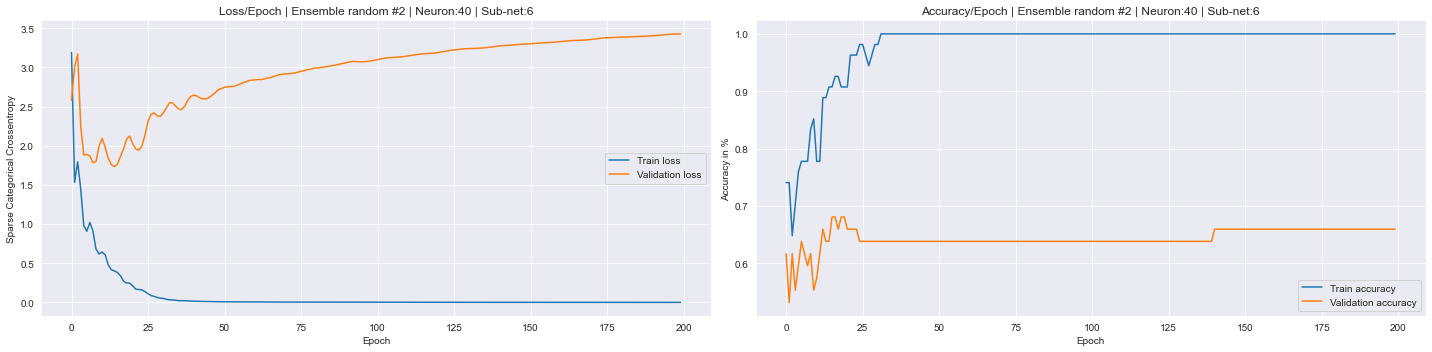

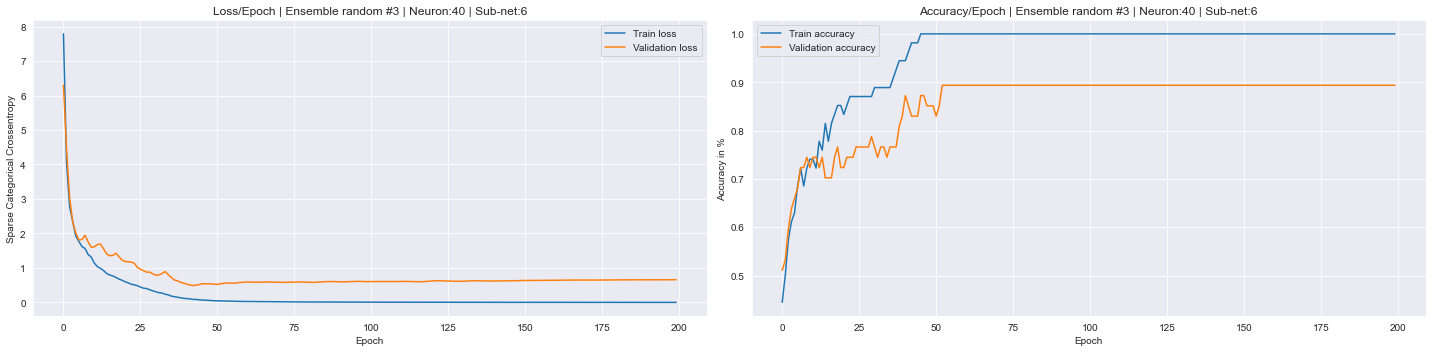

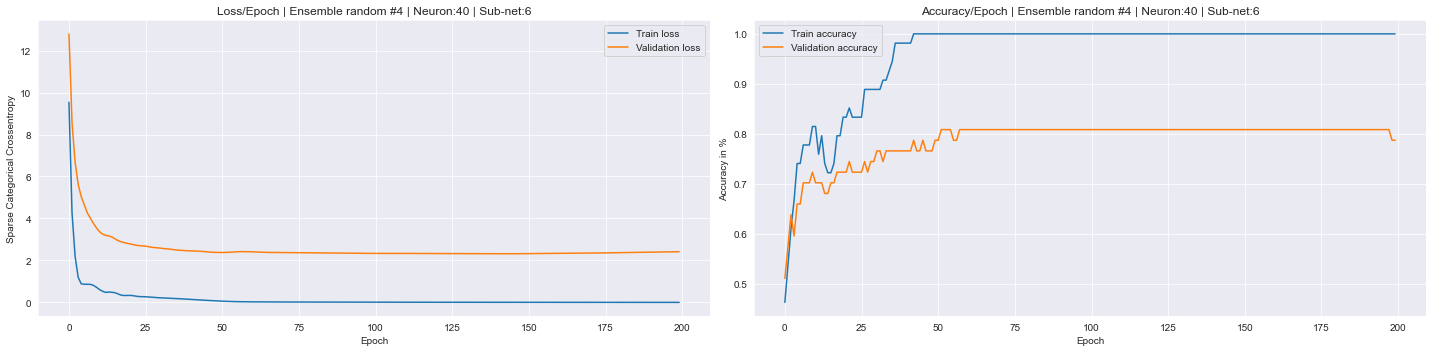

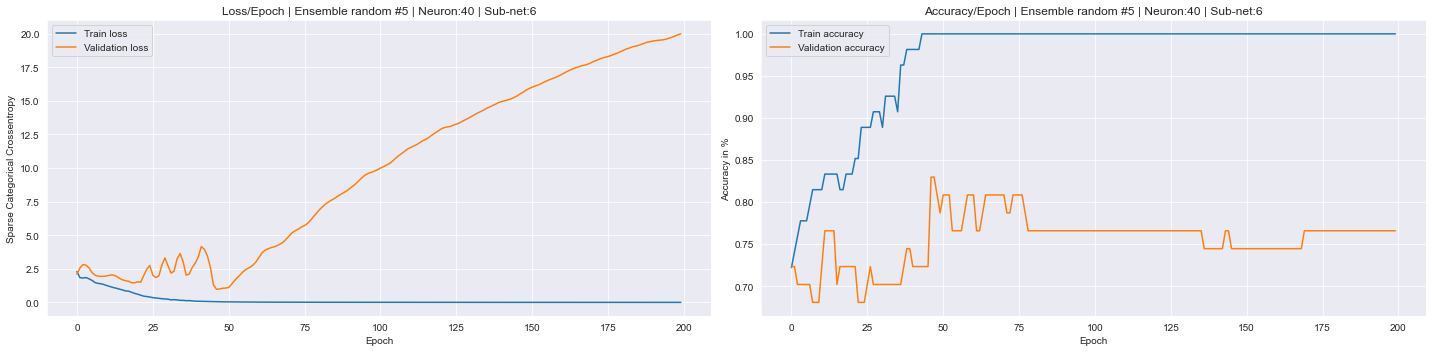

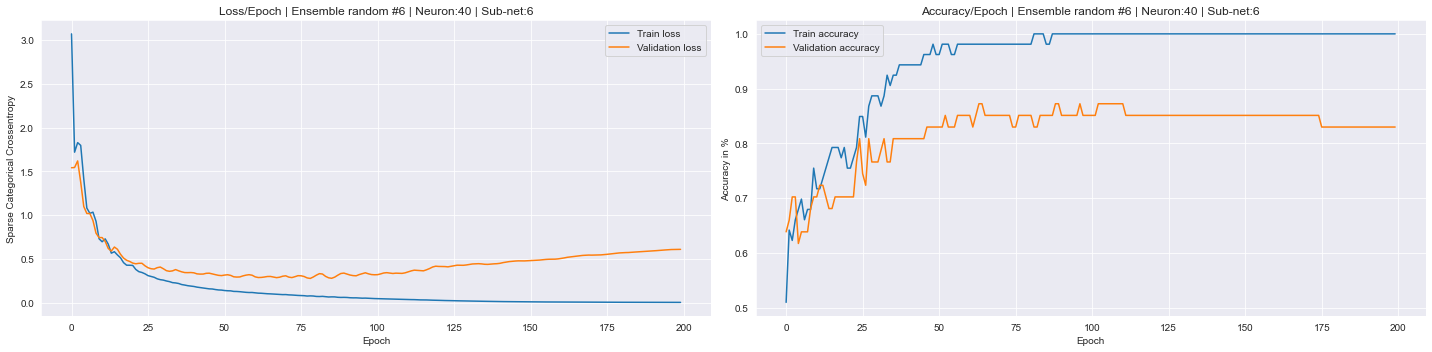

In [12]:
random_sub_net_trainer([40]*6)     

### Sub-net: 8 (Same net)

Passed Elman: 40
3/3 [==============================] - 0s 3ms/step - loss: 0.4056 - accuracy: 0.9032
Passed Elman: 40
3/3 [==============================] - 0s 3ms/step - loss: 1.1394 - accuracy: 0.7097
Passed Elman: 40
3/3 [==============================] - 0s 4ms/step - loss: 1.1967 - accuracy: 0.7634
Passed Elman: 40
3/3 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.7634
Passed Elman: 40
3/3 [==============================] - 0s 2ms/step - loss: 0.8673 - accuracy: 0.8065
Passed Elman: 40
3/3 [==============================] - 0s 6ms/step - loss: 1.2635 - accuracy: 0.7419
Passed Elman: 40
3/3 [==============================] - 0s 2ms/step - loss: 1.2400 - accuracy: 0.7634
Passed Elman: 40
3/3 [==============================] - 0s 2ms/step - loss: 2.3656 - accuracy: 0.7634


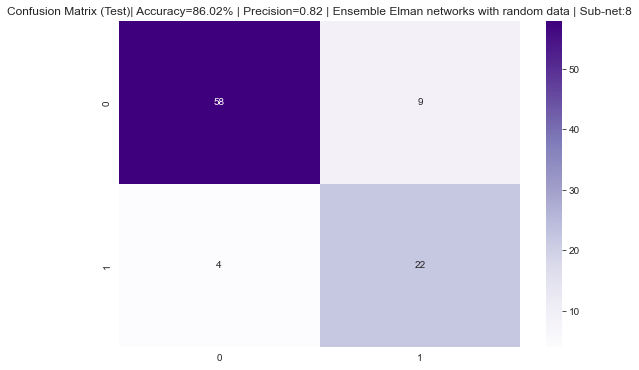

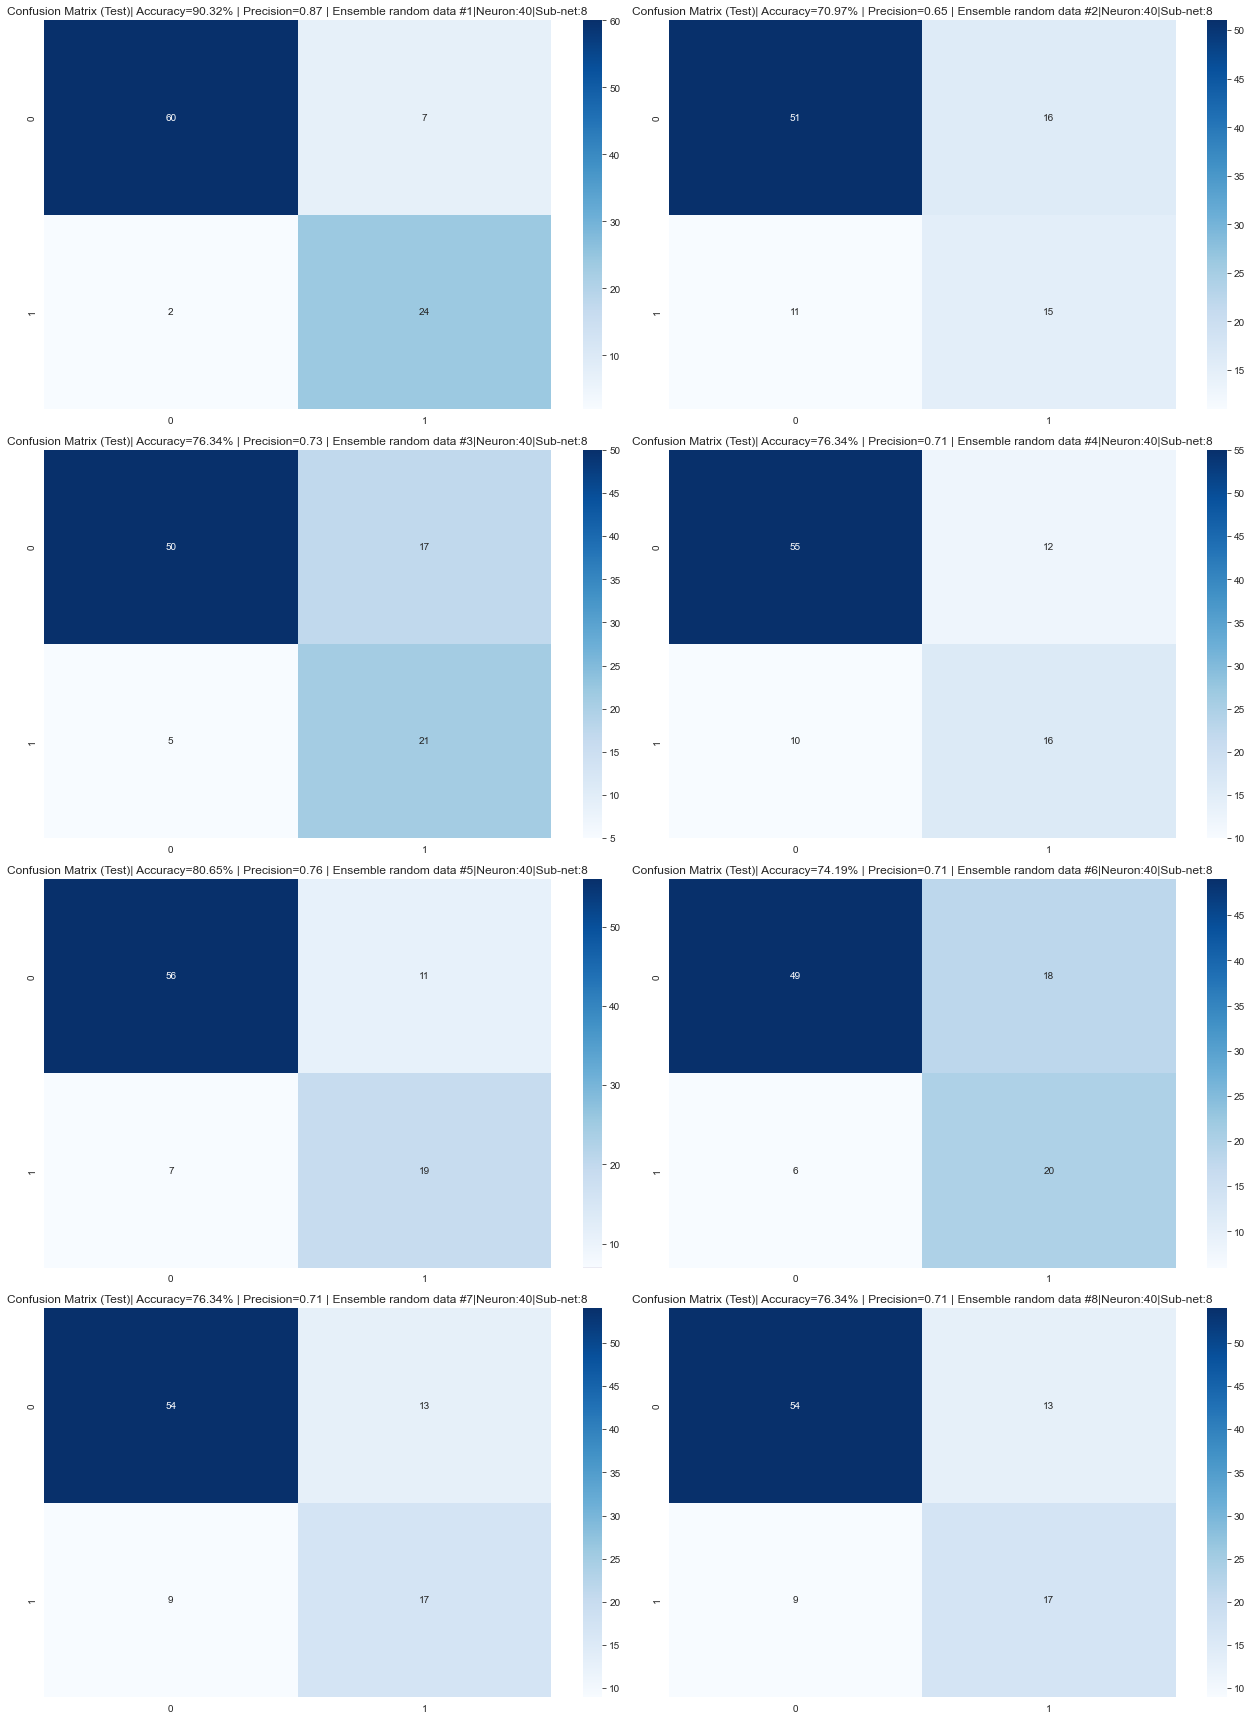

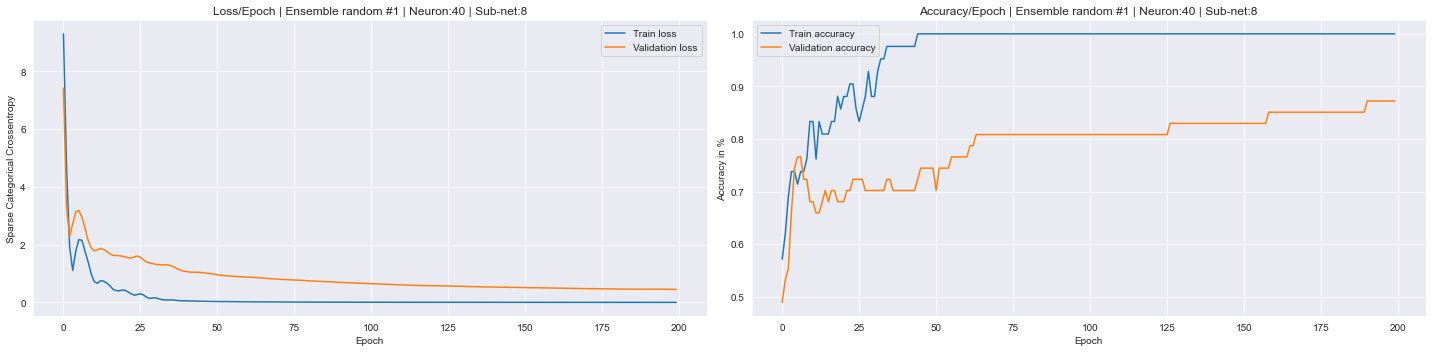

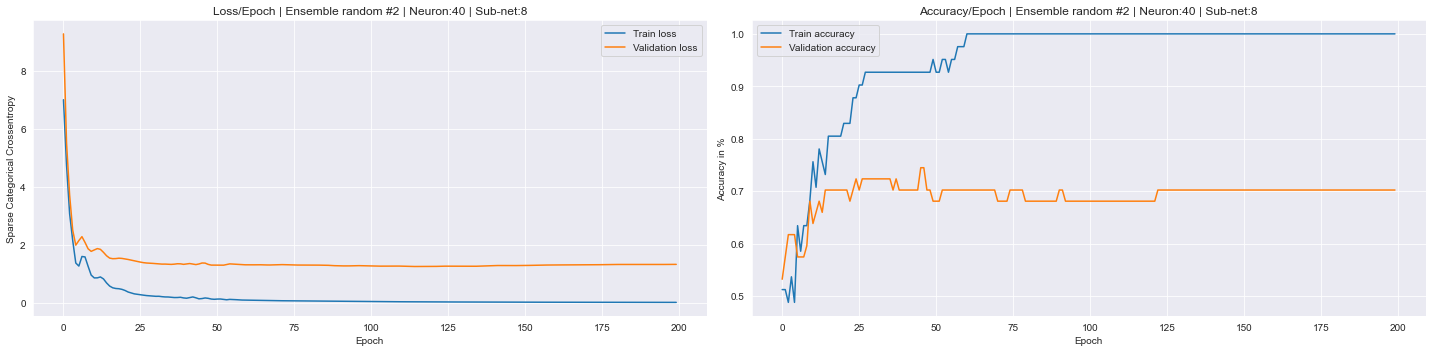

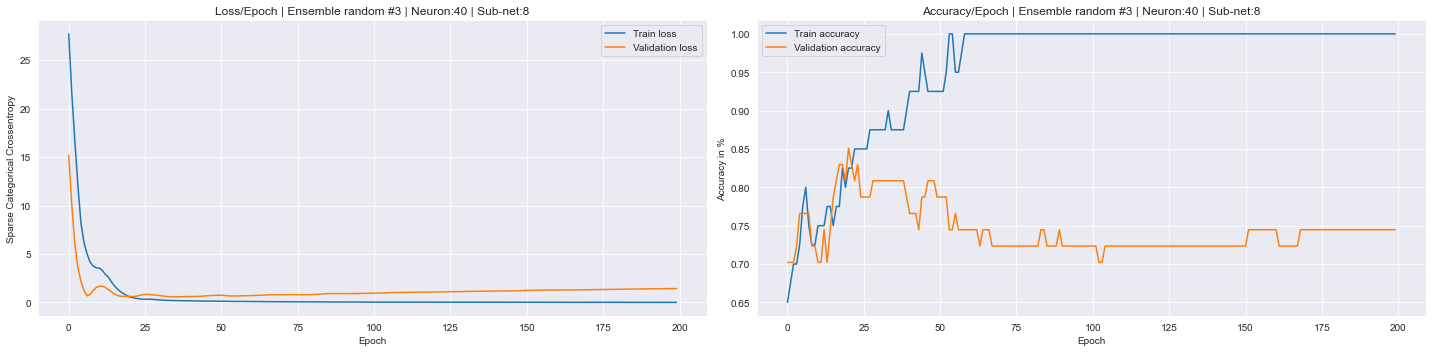

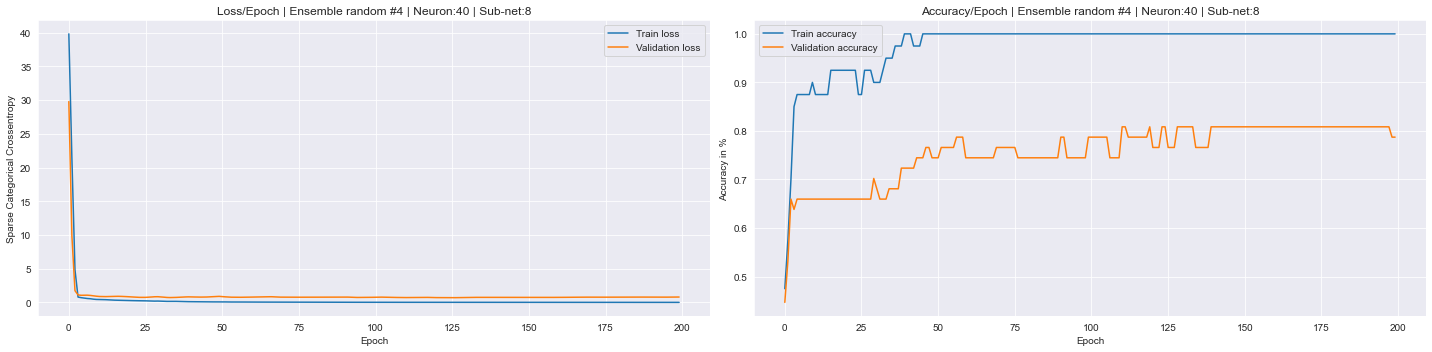

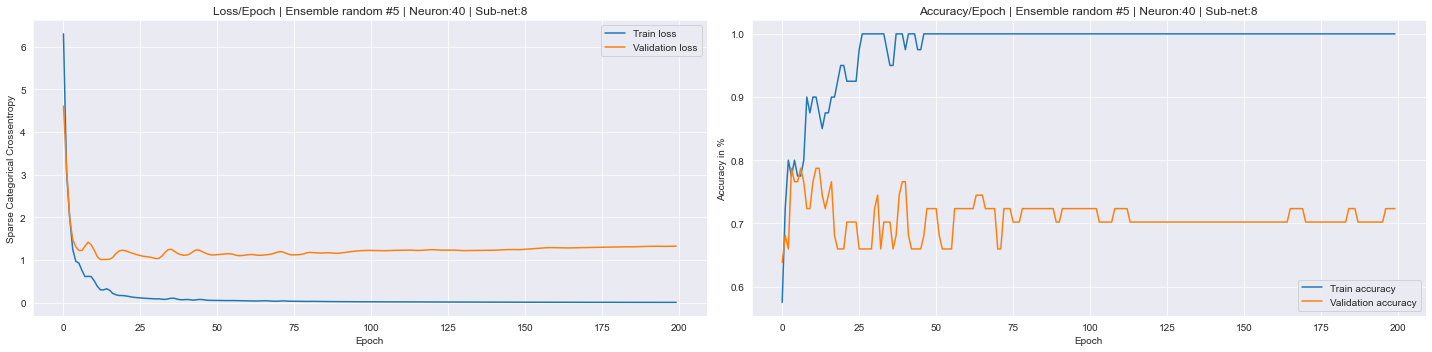

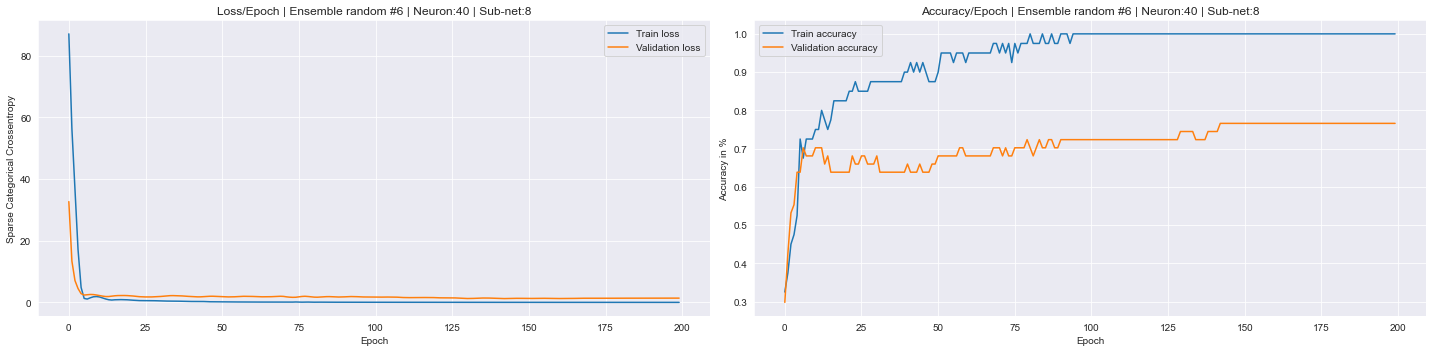

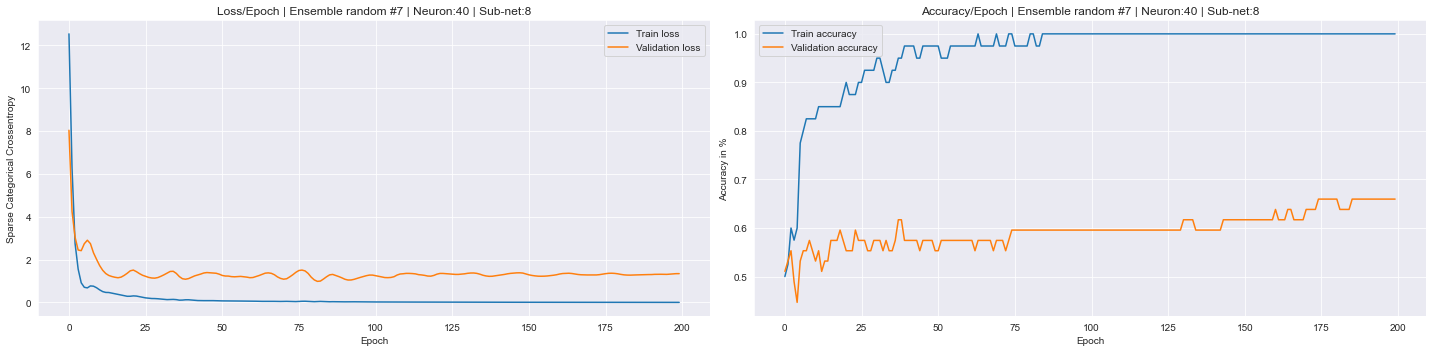

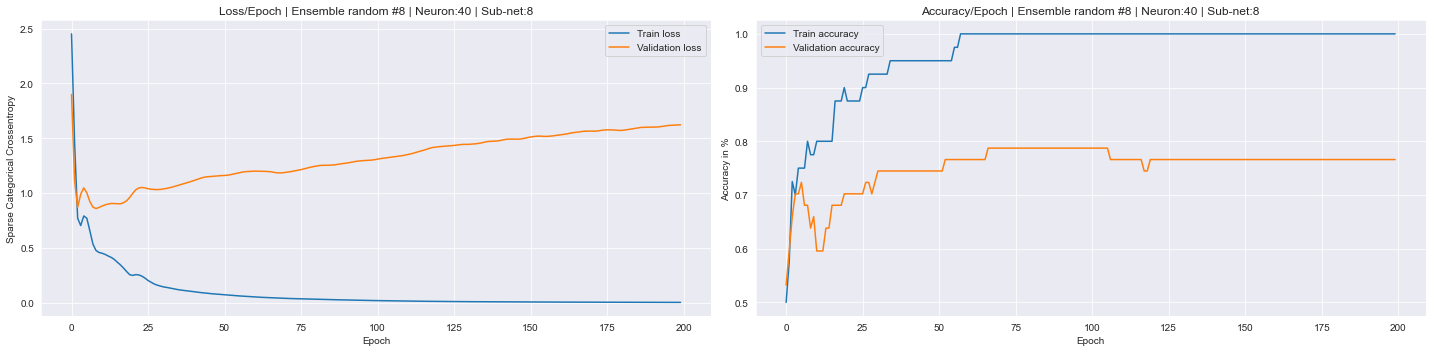

In [13]:
random_sub_net_trainer([40]*8)     

### Sub-net: 4 (simple)

Passed Elman: 20
3/3 [==============================] - 0s 4ms/step - loss: 1.0010 - accuracy: 0.7634
Passed Elman: 20
3/3 [==============================] - 0s 3ms/step - loss: 0.3821 - accuracy: 0.8817
Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 0.8993 - accuracy: 0.8172
Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.9247


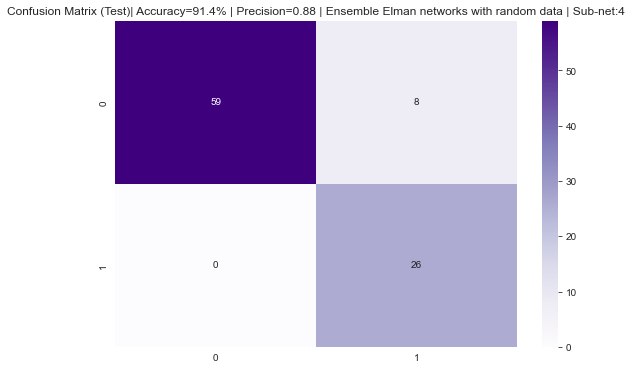

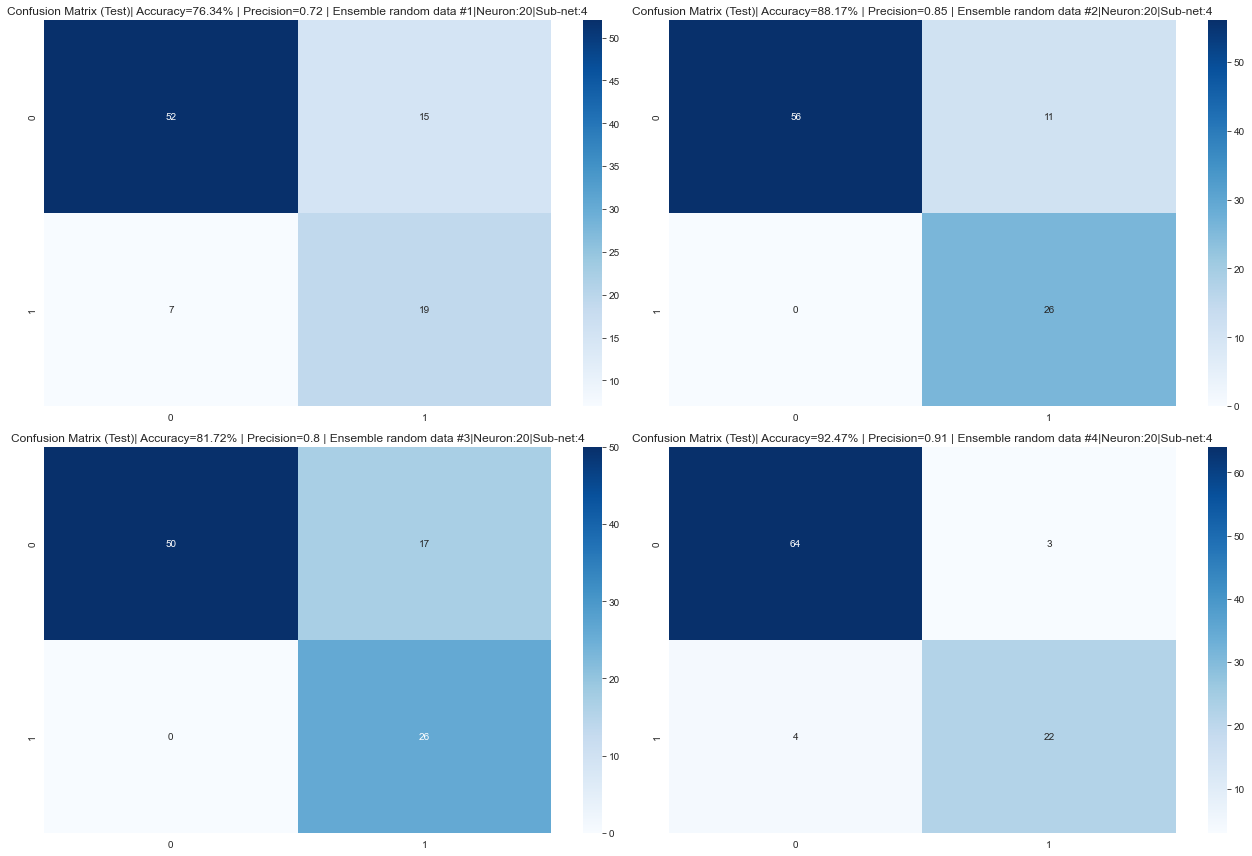

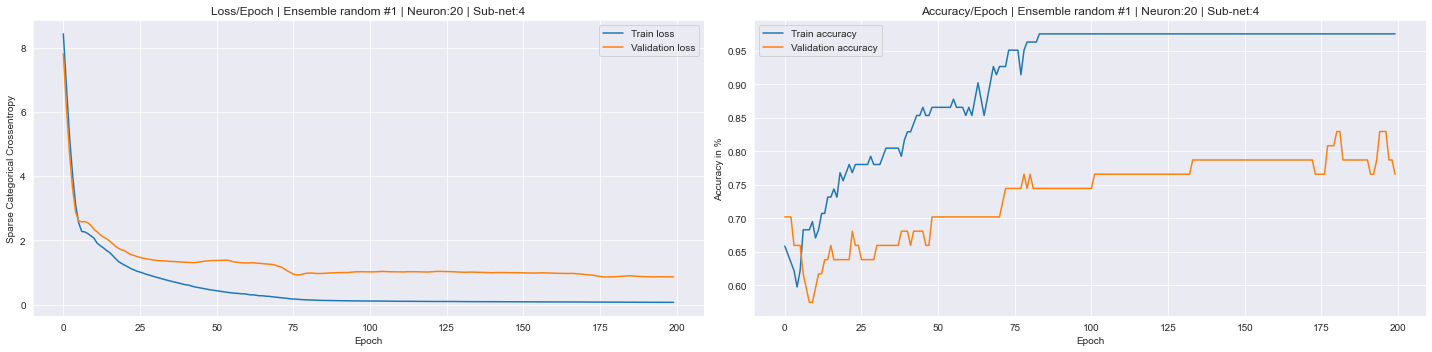

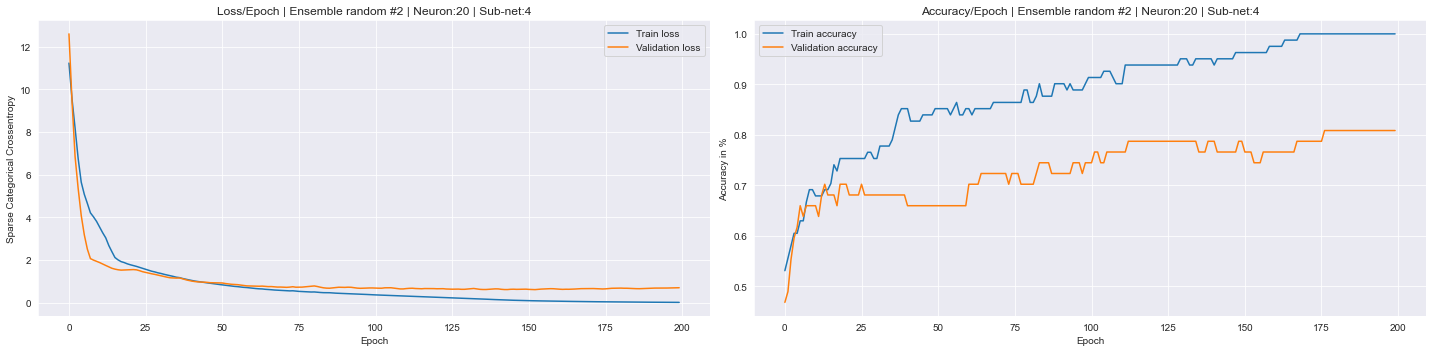

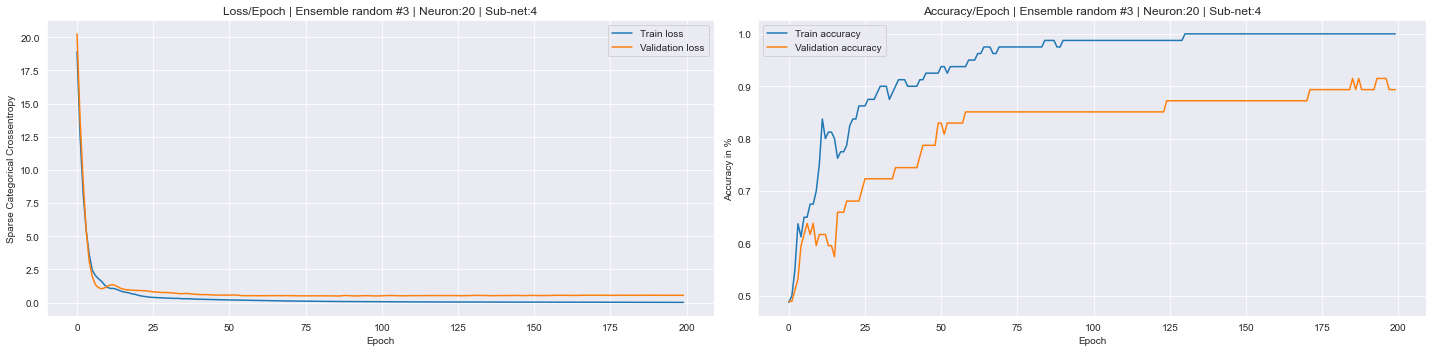

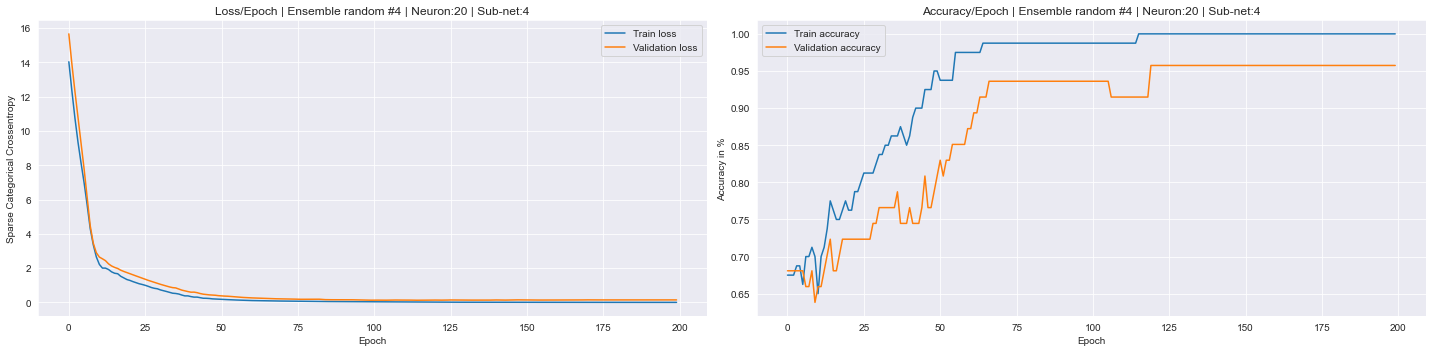

In [19]:
random_sub_net_trainer([20]*4)     

### Sub-net: 8 (simple)

Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 0.7640 - accuracy: 0.7204
Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 1.9200 - accuracy: 0.6667
Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 3.4087 - accuracy: 0.6989
Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 0.8207 - accuracy: 0.7742
Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 1.1312 - accuracy: 0.8172
Passed Elman: 20
3/3 [==============================] - 0s 2ms/step - loss: 0.8916 - accuracy: 0.7527
Passed Elman: 20
3/3 [==============================] - 0s 3ms/step - loss: 0.2383 - accuracy: 0.8817
Passed Elman: 20
3/3 [==============================] - 0s 3ms/step - loss: 1.4715 - accuracy: 0.7419


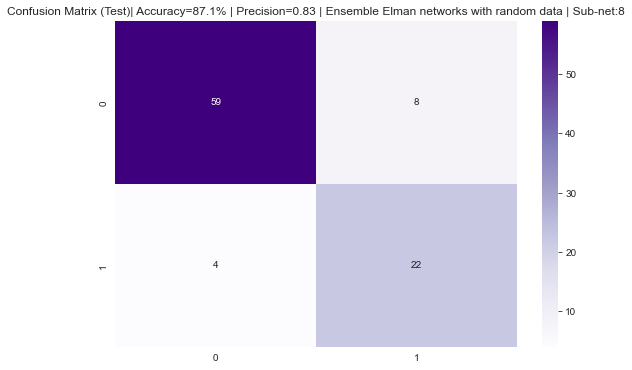

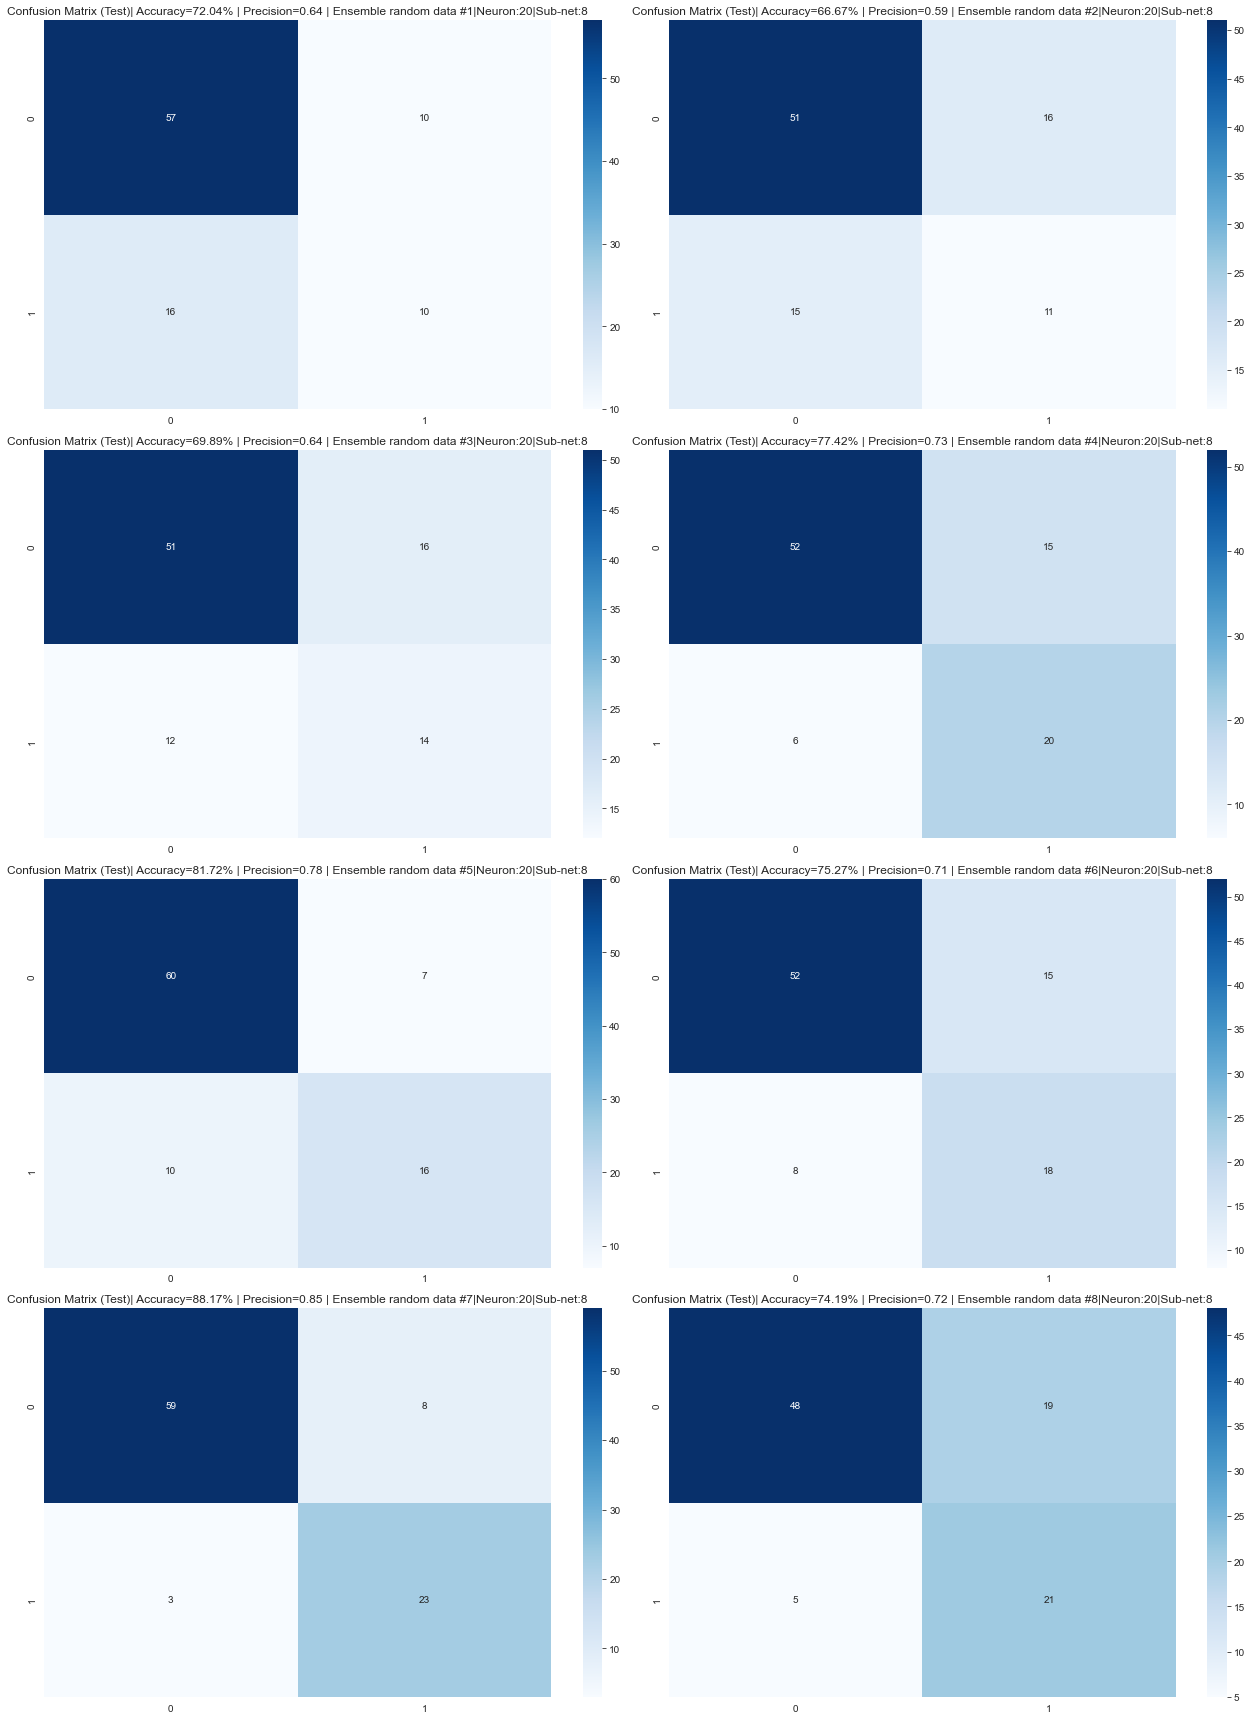

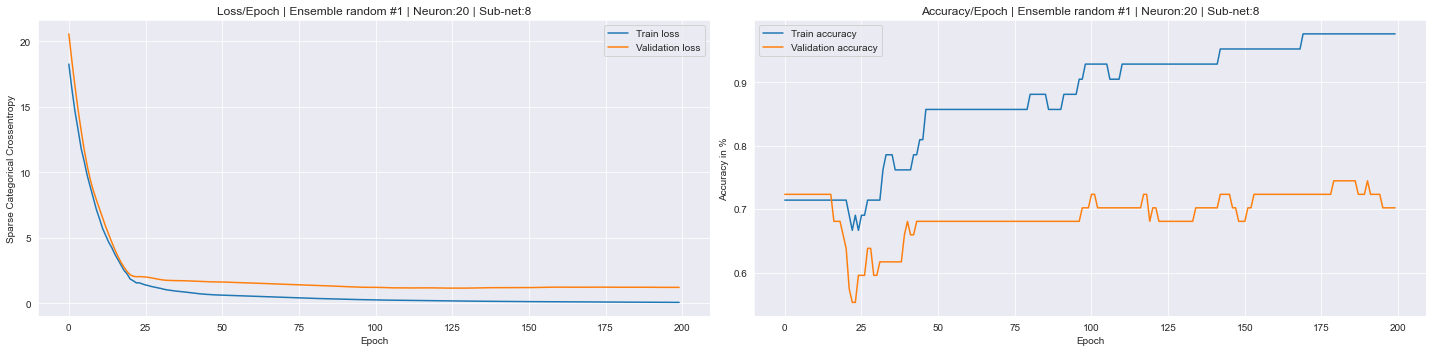

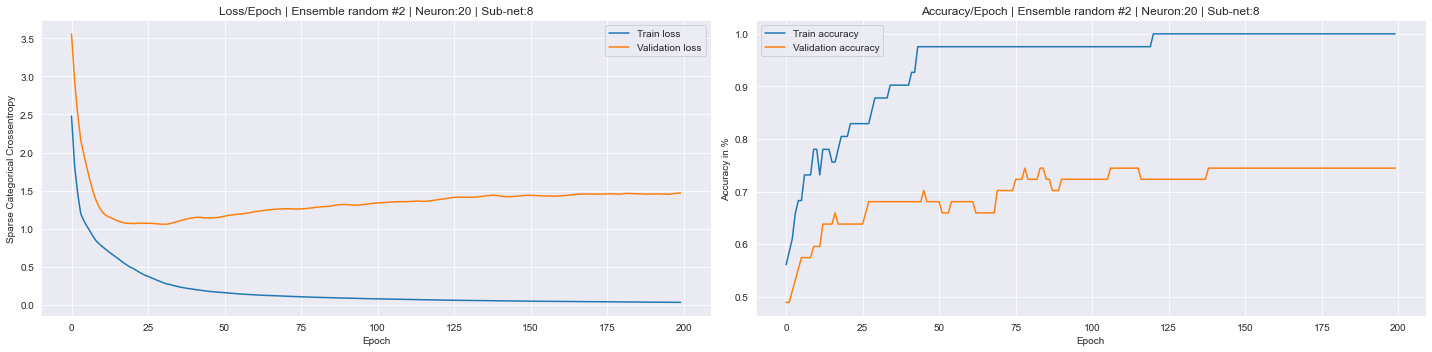

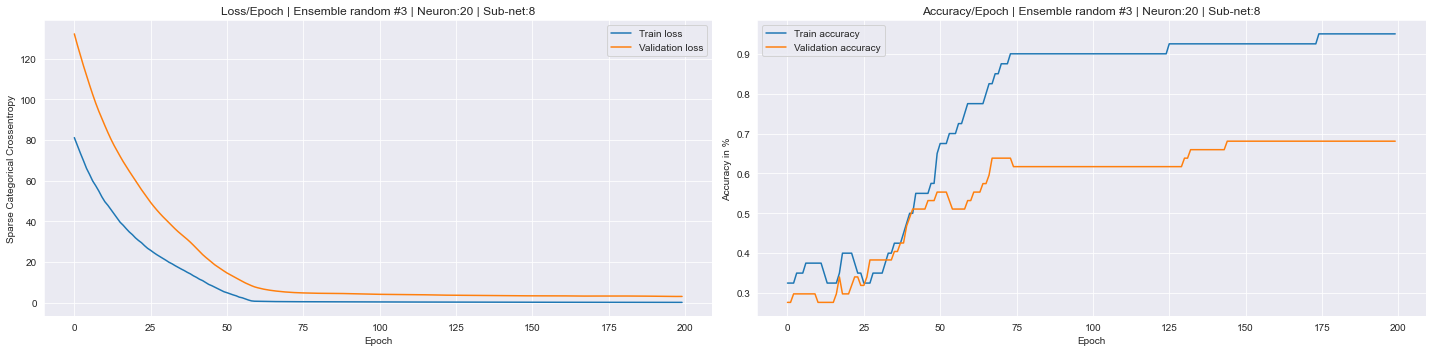

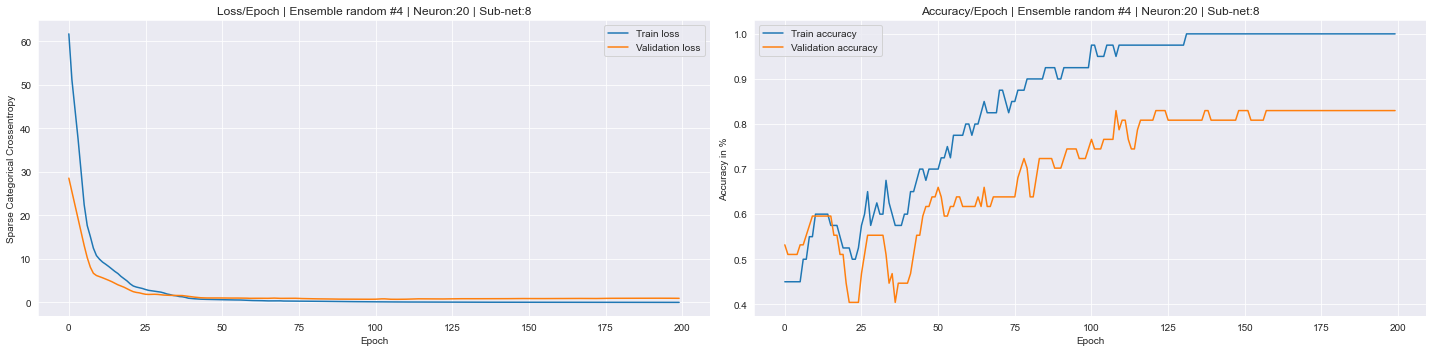

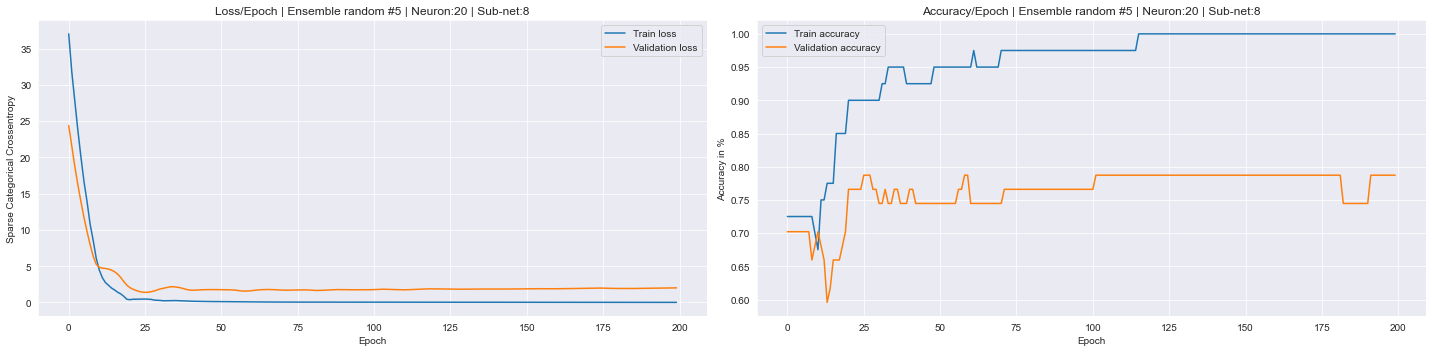

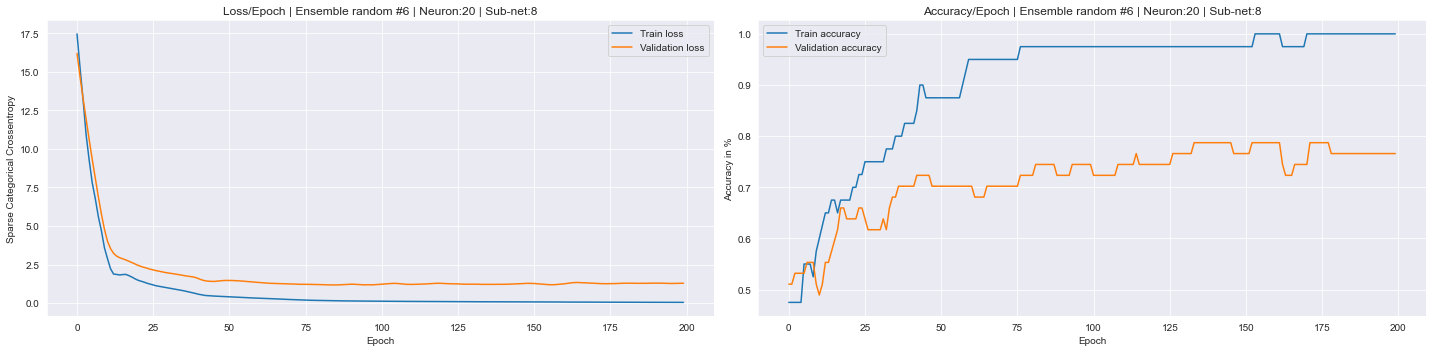

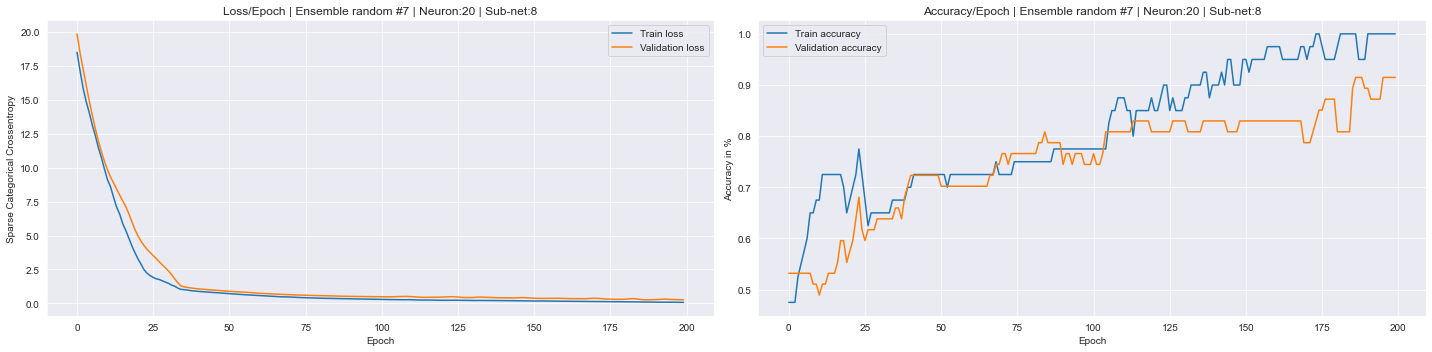

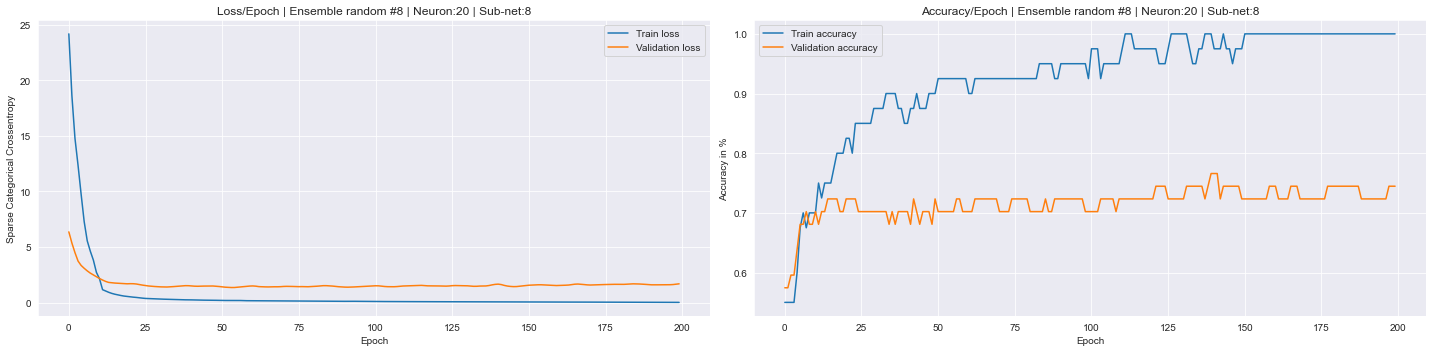

In [20]:
random_sub_net_trainer([20]*8)     